In [1]:
import pickle

In [2]:
import numpy as np

In [3]:
import torch

In [4]:
import pytorch_lightning as pl

In [5]:
import matplotlib.pyplot as plt

In [6]:
with open('../data/df_mcc_features.np', 'rb') as f:
    np_features = pickle.load(f)

In [7]:
data_orig = torch.from_numpy(np_features).unsqueeze(0).float()

In [8]:
B, T, C = data_orig.shape  # Batch, Timeline, Channels
B, T, C

(1, 457, 100)

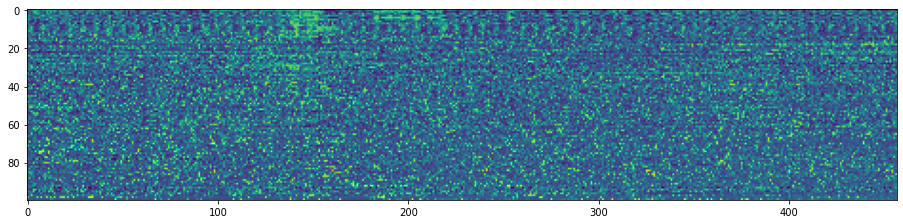

In [9]:
a = data_orig[0].abs()
a = np.clip(a, *np.percentile(a, [5, 95], axis=0))
a = a - a.mean(dim=0, keepdims=True)
a = a / a.std(dim=0, keepdims=True)

plt.figure(figsize=(16, 16 * C / T))
plt.imshow(a.T)
plt.show()

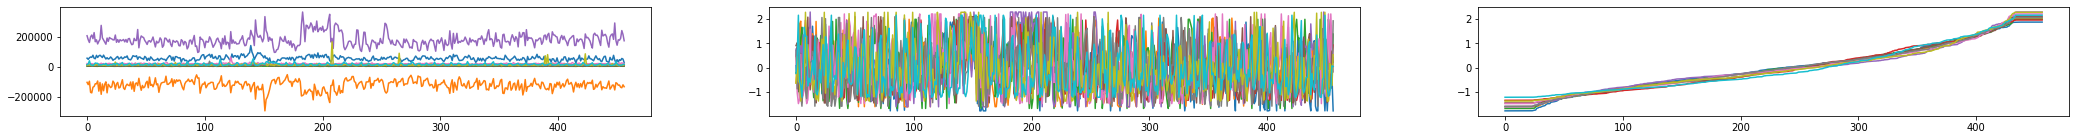

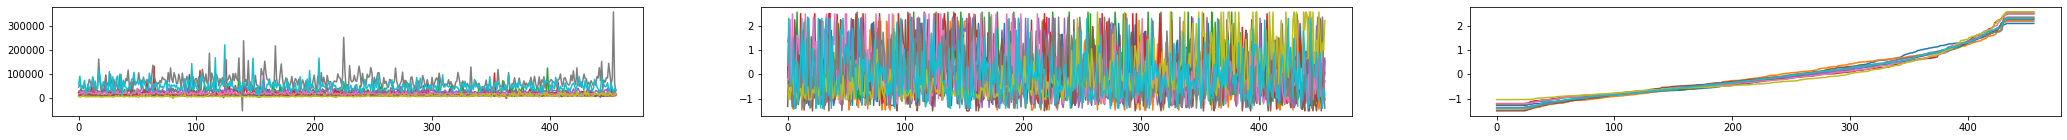

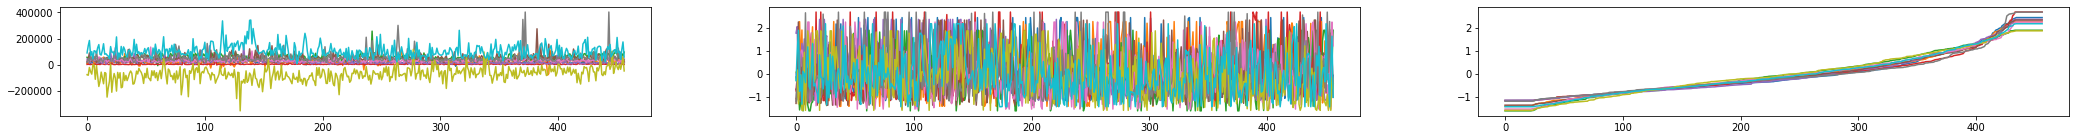

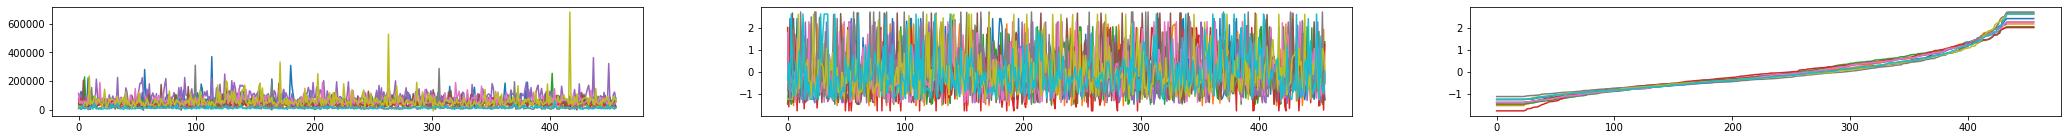

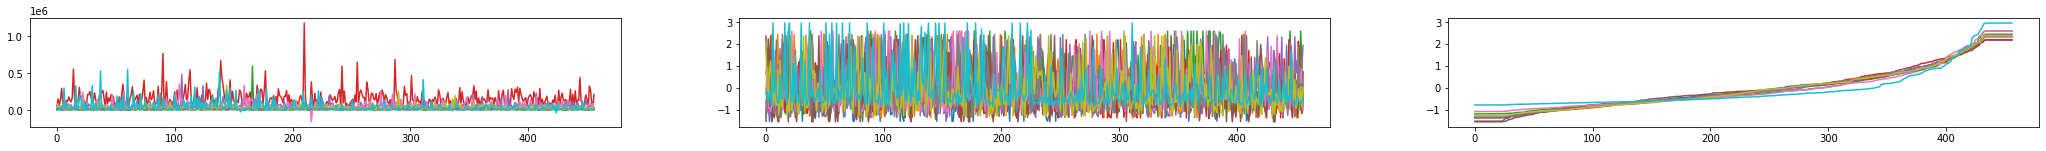

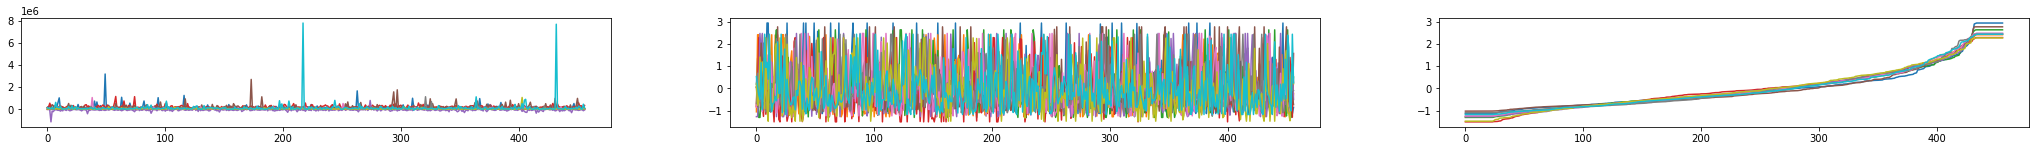

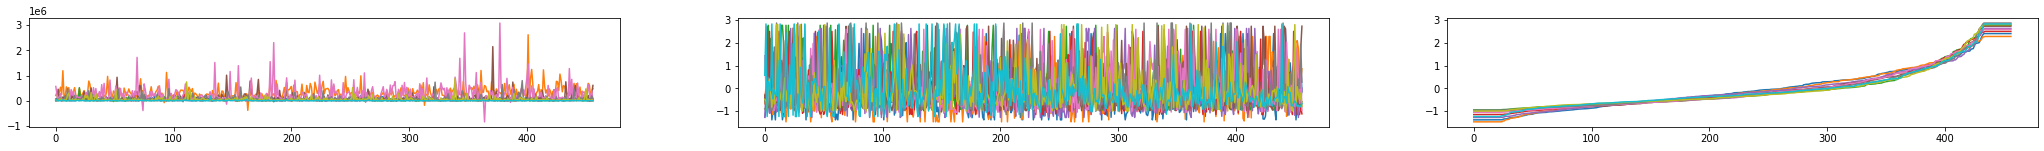

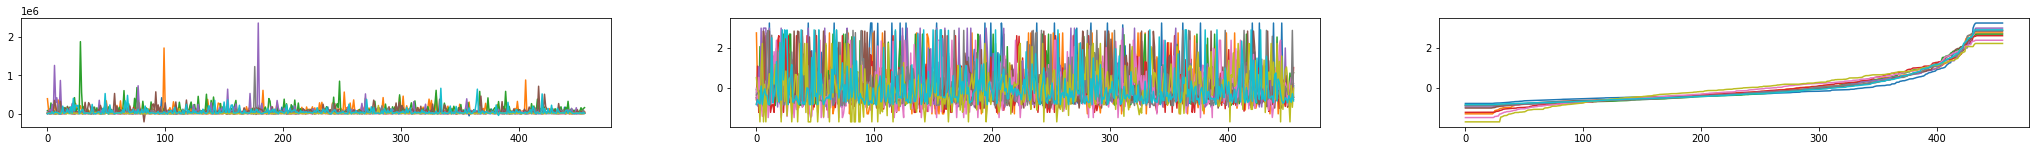

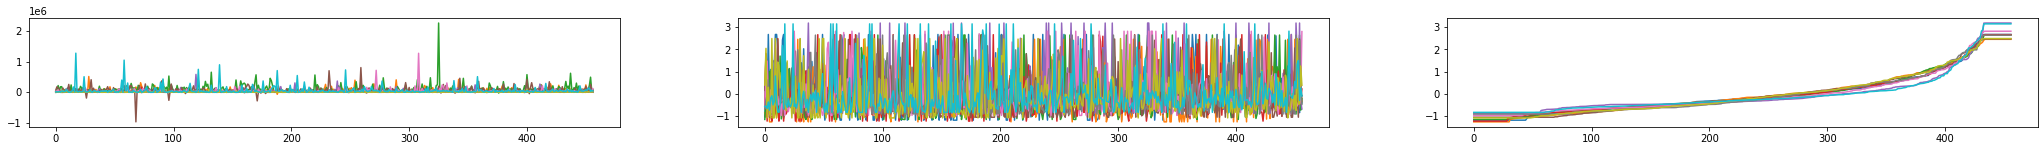

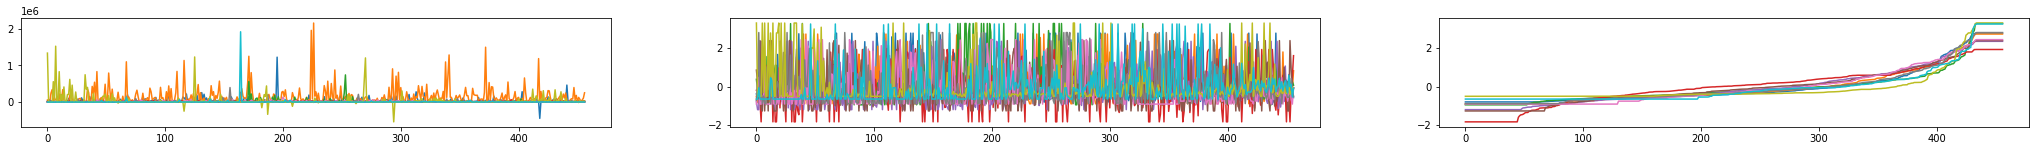

In [11]:
for i in range(0, 100, 10):
    _, axs = plt.subplots(1, 3, figsize=(36, 2))
    axs[0].plot(data_orig[0, :, i:i+10])
    axs[1].plot(a[:, i:i+10])
    for j in range(10):
        v = a[:, i:i+10][:, j]
        v = torch.sort(v).values
        axs[2].plot(v)
    plt.show()

In [12]:
def plot_corr_matrix(a, b):
    a = a - a.mean(dim=0, keepdim=True)
    a = a / a.std(dim=0, keepdim=True)
    b = b - b.mean(dim=0, keepdim=True)
    b = b / b.std(dim=0, keepdim=True)

    m = (torch.mm(a.T, b) / len(b)).abs().numpy()
    max_mf = m.max(axis=1)
    max_mz = m.max(axis=0)

    _, axs = plt.subplots(1, 3, figsize=(16, 4))

    axs[0].plot(np.arange(len(max_mf)), max_mf[np.argsort(max_mf)])
    axs[0].set_title(f'Mean feature cor: {max_mf.mean():.3f}, max: {max_mf.max():.3f}')
    axs[1].plot(np.arange(len(max_mz)), max_mz[np.argsort(max_mz)])
    axs[1].set_title(f'Mean embedding cor: {max_mz.mean():.3f}, max: {max_mz.max():.3f}')

    i = axs[2].imshow(m)
    plt.colorbar(i, ax=axs[2])

    plt.show()

In [13]:
class InputNorm(torch.nn.Module):
    def __init__(self, num_channels, clip_range):
        super().__init__()
        self.bn = torch.nn.BatchNorm1d(num_channels)
        self.clip_range = clip_range
        
    def forward(self, x):
        B, T, C = x.size()
        x = self.bn(x.view(B * T, C)).view(B, T, C)
        x = torch.clamp(x, *self.clip_range)
        return x

In [113]:
a = torch.arange(10)

In [123]:
a[:-1]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [798]:
class TBatchNorm(torch.nn.BatchNorm1d):
    def forward(self, x):
        B, T, C = x.size()
        return super().forward(x.view(B * T, C)).view(B, T, C)

In [1073]:
class StreamEncoder(pl.LightningModule):
    def __init__(self, 
                 train_batch_size, history_size, predict_size,
                 in_channels, clip_range,
                 z_channels,
                 c_channels,
                 var_gamma,
                 lr, weight_decay, step_size, gamma,
                 cpc_w, cov_w, var_w,
                ):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.input_model = InputNorm(in_channels, clip_range)
        
        self.cnn_encoder = torch.nn.Linear(in_channels, z_channels)
        self.cnn_encoder = torch.nn.Sequential(
            torch.nn.Linear(in_channels, z_channels),
            TBatchNorm(z_channels),
        )
        
        self.ar_rnn = torch.nn.GRU(
            input_size=z_channels,
            hidden_size=c_channels,
            batch_first=True,
        )
        
        self.lin_predictors = torch.nn.ModuleList([
            torch.nn.Linear(c_channels, z_channels) for _ in range(predict_size)
        ])
        
        self.reg_bn = torch.nn.BatchNorm1d(c_channels, affine=False)
        
    def get_train_dataloader(self, data):
        def gen_batches(data):
            B, T, C = data.size()
            sample_len = self.hparams.history_size + self.hparams.predict_size
            for b in range(B):
                for i in range(0, T - sample_len):
                    yield data[b, i:i + sample_len]
        
        all_batches = torch.stack(list(gen_batches(data)))
        
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(all_batches),
            shuffle=True,
            batch_size=self.hparams.train_batch_size,
            persistent_workers=True, 
            num_workers=4,
        )
        
    def get_valid_dataloader(self, data):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(data),
            batch_size=1,
        )
        
    def configure_optimizers(self):
        optimisers = [torch.optim.Adam(self.parameters(),
                                       lr=self.hparams.lr,
                                       weight_decay=self.hparams.weight_decay,
                                      )]
        schedulers = [torch.optim.lr_scheduler.StepLR(o, 
                                                      step_size=self.hparams.step_size,
                                                      gamma=self.hparams.gamma) for o in optimisers]
        return optimisers, schedulers
        
    def forward(self, x):
        x = self.input_model(x)
        z = self.cnn_encoder(x)
        c, h = self.ar_rnn(z)
        return x, z, c
    
    def training_step(self, batch, batch_idx):
        x = self.input_model(batch[0])
        z = self.cnn_encoder(x)

        zx, zy = z[:, :self.hparams.history_size], z[:, self.hparams.history_size:]
        
        cpc_loss, cx = self.cpc_loss(zx, zy)
        cov_loss = self.cov_loss(cx)
        var_loss = self.var_loss(cx)
        loss = 0.0
        if self.hparams.cpc_w > 0:
            loss += self.hparams.cpc_w * cpc_loss
        if self.hparams.cov_w > 0:
            loss += self.hparams.cov_w * cov_loss
        if self.hparams.var_w > 0:
            loss += self.hparams.var_w * var_loss
        
        self.log('cpc_loss', cpc_loss, prog_bar=True)
        self.log('cov_loss', cov_loss, prog_bar=True)
        self.log('var_loss', var_loss, prog_bar=True)
        self.log('loss', loss)
        
        return loss
    
    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {
            "hp/zf_cor": 0,
            "hp/ze_cor": 0,
            "hp/cf_cor": 0, 
            "hp/ce_cor": 0,
        })

    def plot_xzc(self, x, z, c):
        x = x[0, :500].detach().cpu().numpy()
        z = z[0, :500].detach().cpu().numpy()
        c = c[0, :500].detach().cpu().numpy()
        
        # plot signal
        fig, axs = plt.subplots(3, 1, figsize=(12, 4 * 3))
        axs[0].plot(x)
        axs[0].set_title('x signal')
        axs[1].plot(z)
        axs[1].set_title('z signal')
        axs[2].plot(c)
        axs[2].set_title('c signal')
        plt.suptitle('embedding signals')
        self.logger.experiment.add_figure('Signals', fig, global_step=self.global_step)

        # plot spectrum
        fig, axs = plt.subplots(3, 1, figsize=(12, 3 * 12 * x.shape[1] / x[0, :500].shape[0]))
        axs[0].imshow(x.T)
        axs[0].set_title('x spectrum')
        axs[1].imshow(z.T)
        axs[1].set_title('z spectrum')
        axs[2].imshow(c.T)
        axs[2].set_title('c spectrum')
        self.logger.experiment.add_figure('Spectrum', fig, global_step=self.global_step)
        
    def validation_step(self, batch, batch_idx):
        x, z, c = self.forward(batch[0])
#         self.plot_xzc(x, z, c)

        z = z - z.mean(dim=1, keepdim=True)
        z = z / z.std(dim=1, keepdim=True)
        c = c - c.mean(dim=1, keepdim=True)
        c = c / c.std(dim=1, keepdim=True)

        m = (torch.bmm(x.transpose(1, 2), z) / x.size(1)).abs()
        self.log('hp/zf_cor', m.max(dim=2).values.mean())
        self.log('hp/ze_cor', m.max(dim=1).values.mean())

        m = (torch.bmm(x.transpose(1, 2), c) / x.size(1)).abs()
        self.log('hp/cf_cor', m.max(dim=2).values.mean())
        self.log('hp/ce_cor', m.max(dim=1).values.mean())
        
    def cpc_loss(self, x, y):
        out, h = self.ar_rnn(x)
        c = h[0]  # B, Hc
        
        loss = 0.0
        for i, l in enumerate(self.lin_predictors):
            p = l(c)
            t = y[:, i]
            loss += (p - t).pow(2).sum(dim=1).mean()
        
        return loss / self.hparams.predict_size, c
    
    def cov_loss(self, x):
#         B, T, C = x.size()
#         x = self.reg_bn(x.reshape(B * T, C)).view(B, T, C)
#         m = torch.bmm(x.transpose(1, 2), x) / T  # B, C, C
#         off_diag_ix = (1 - torch.eye(C)).bool().view(-1)
#         loss = m.view(B, C * C)[:, off_diag_ix].view(-1).pow(2).mean()
        B, C = x.size()
        x = self.reg_bn(x)
        m = torch.mm(x.T, x) / B  # C, C
        off_diag_ix = (1 - torch.eye(C, device=x.device)).bool().view(-1)
        loss = m.view(C * C)[off_diag_ix].pow(2).mean()
        return loss
    
    def var_loss(self, x):
#         B, T, C = x.size()
        
#         v = (torch.var(x.reshape(B * T, C), dim=0) + 1e-6).pow(0.5)
        B, C = x.size()
        v = (torch.var(x, dim=0) + 1e-6).pow(0.5)
        loss = torch.relu(self.hparams.var_gamma - v).mean()
        return loss


# Run

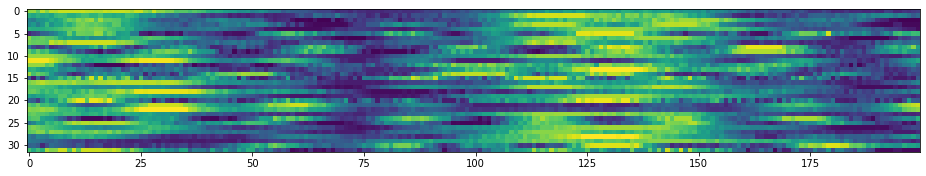

In [610]:
N = 10000
n_dim = 8
data_sin = torch.arange(N).view(-1, 1).repeat(1, n_dim)
data_sin = (torch.rand(1, n_dim) * 10 + 1) * \
    torch.sin(2 * np.pi * data_sin / (torch.rand(1, n_dim) * 190 + 10) + 2 * np.pi * torch.rand(1, n_dim)) + \
    (torch.rand(1, n_dim) * 10 - 1)
data_sin = torch.mm(data_sin, torch.randn(8, 32))
data_sin += torch.randn_like(data_sin) * 1
data_sin = data_sin.unsqueeze(0)

a = data_sin[0, :200].abs()
a = np.clip(a, *np.percentile(a, [5, 95], axis=0))
a = a - a.mean(dim=0, keepdims=True)
a = a / a.std(dim=0, keepdims=True)

plt.figure(figsize=(16, 16 * C / T))
plt.imshow(a.numpy().T)
plt.show()

In [1032]:
# # for sin
# model = StreamEncoder(
#     train_batch_size=128, history_size=28, predict_size=3,
#     in_channels=32, clip_range=(-2.5, 2.5),
#     z_channels=16,
#     c_channels=16,
#     var_gamma=0.2, 
#     lr=0.00005, weight_decay=0.0, step_size=10, gamma=0.8,
#     cpc_w=0.1, cov_w=2.0, var_w=0.1,
# )

In [1127]:
# for mcc
model = StreamEncoder(
    train_batch_size=32, history_size=28, predict_size=3,
    in_channels=100, clip_range=(-2.5, 2.5),
    z_channels=32,
    c_channels=32,
    var_gamma=0.3,
    lr=0.001, weight_decay=0.0001, step_size=25, gamma=0.8,
    cpc_w=0.1, cov_w=2.0, var_w=0.4,
)

In [1128]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=200,
    log_every_n_steps=10,
    progress_bar_refresh_rate=50,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [1129]:
train_dl = model.get_train_dataloader(data_orig)
valid_dl = model.get_valid_dataloader(data_orig)

In [1130]:
# train_dl = model.get_train_dataloader(data_sin)
# valid_dl = model.get_valid_dataloader(data_sin)

In [1131]:
batch = next(iter(train_dl))[0]

In [1132]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type        | Params
-----------------------------------------------
0 | input_model    | InputNorm   | 200   
1 | cnn_encoder    | Sequential  | 3.3 K 
2 | ar_rnn         | GRU         | 6.3 K 
3 | lin_predictors | ModuleList  | 3.2 K 
4 | reg_bn         | BatchNorm1d | 0     
-----------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [1133]:
model.eval()

# data_norm, z, c = [torch.cat(v, dim=1) for v in zip(model(data_orig[:, :200]), model(data_orig[:, 200:]))]
data_norm, z, c = model(data_orig)

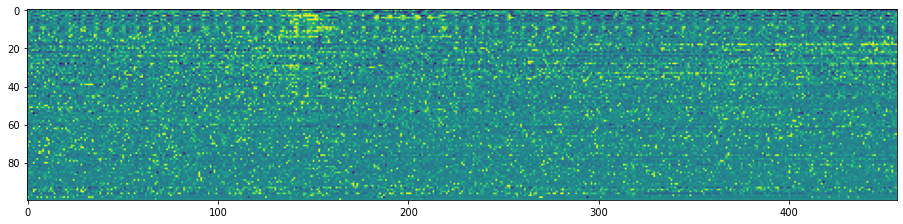

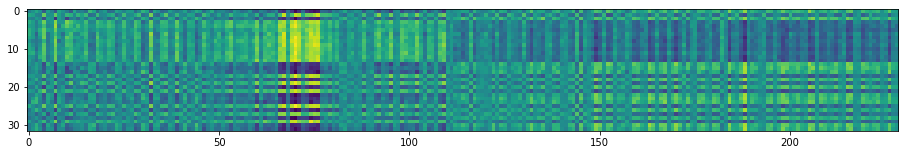

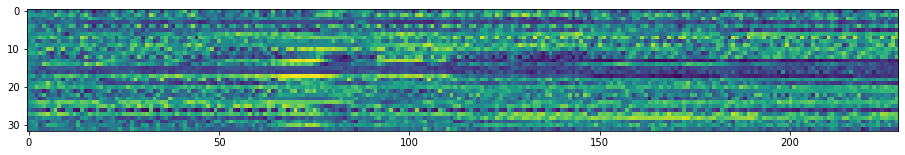

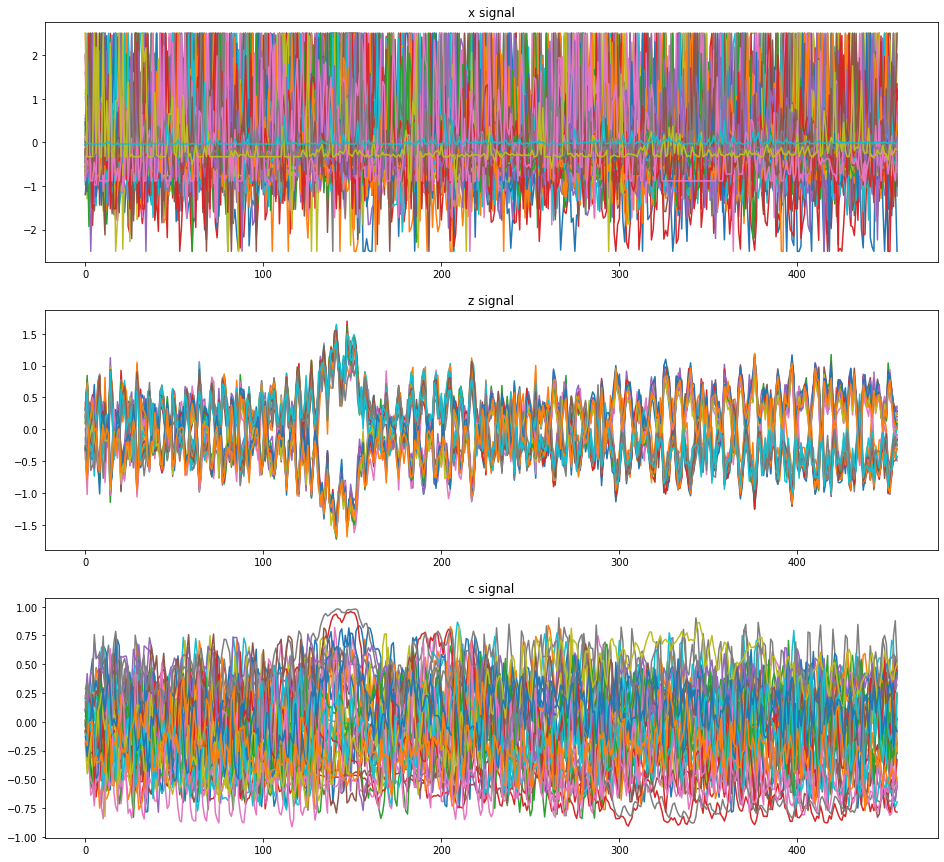

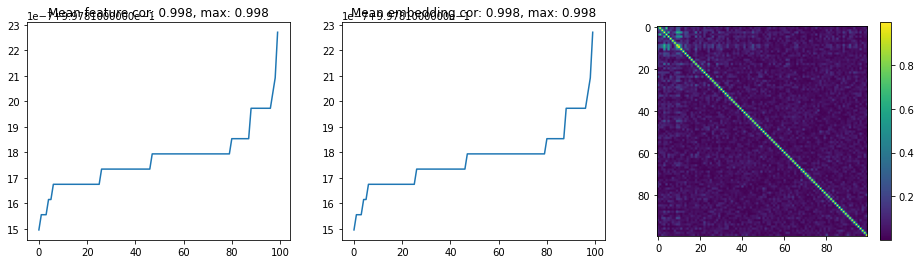

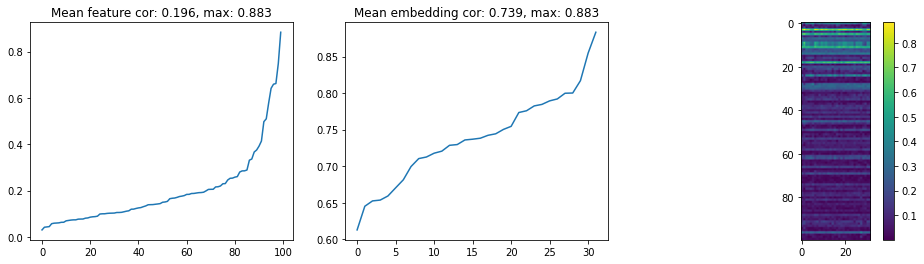

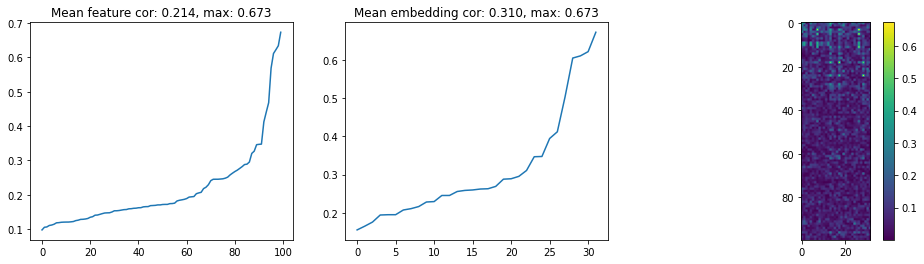

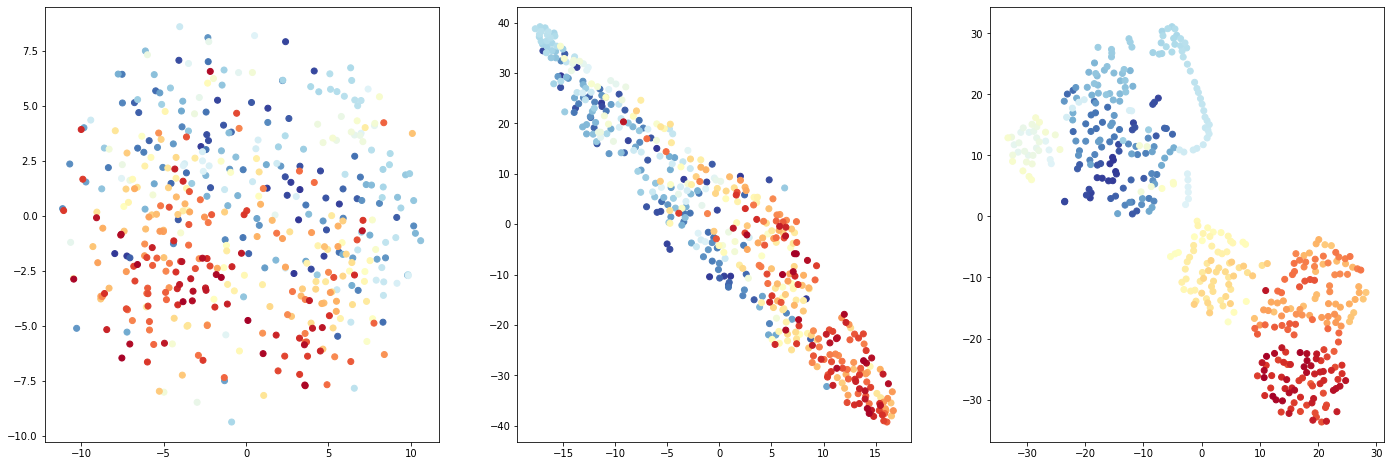

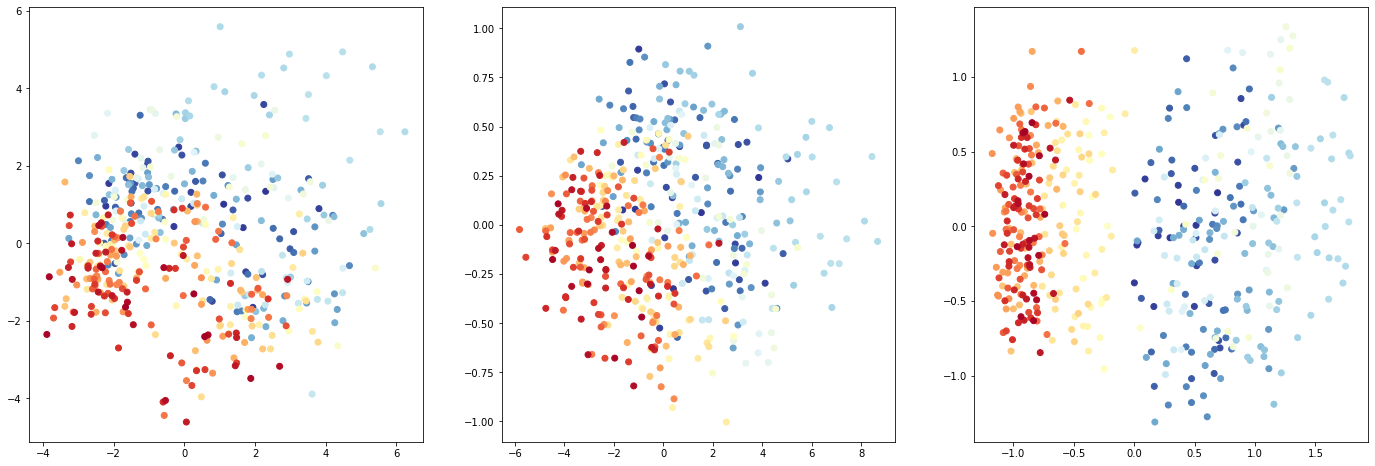

In [1134]:
a = data_norm[0].detach().numpy()
plt.figure(figsize=(16, 16 * data_norm.size(2) / data_norm.size(1)))
plt.imshow(a.T)
plt.show()

a = z[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * z.size(2) / z.size(1)))
plt.imshow(a.T[:, ::2])
plt.show()

a = c[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T[:, ::2])
plt.show()

_, axs = plt.subplots(3, 1, figsize=(16, 5 * 3))
axs[0].plot(data_norm[0].detach().numpy())
axs[0].set_title('x signal')
axs[1].plot(z[0].detach().numpy())
axs[1].set_title('z signal')
axs[2].plot(c[0].detach().numpy())
axs[2].set_title('c signal')
plt.show()

plot_corr_matrix(data_norm[0].detach(), data_norm[0].detach())
plot_corr_matrix(data_norm[0].detach(), z[0].detach())
plot_corr_matrix(data_norm[0].detach(), c[0].detach())



from sklearn.manifold import TSNE

_, axs = plt.subplots(1, 3, figsize=(8 * 3, 8))

tsne = TSNE(2)
axs[0].scatter(*tsne.fit_transform(data_norm[0].detach().numpy()).T, c=np.arange(len(a)), cmap='RdYlBu_r')
axs[1].scatter(*tsne.fit_transform(z[0].detach().numpy()).T, c=np.arange(len(a)), cmap='RdYlBu_r')
axs[2].scatter(*tsne.fit_transform(c[0].detach().numpy()).T, c=np.arange(len(a)), cmap='RdYlBu_r')

plt.show()

from sklearn.decomposition import PCA

_, axs = plt.subplots(1, 3, figsize=(8 * 3, 8))

pca = PCA(2)
axs[0].scatter(*pca.fit_transform(data_norm[0].detach().numpy()).T, c=np.arange(len(a)), cmap='RdYlBu_r')
axs[1].scatter(*pca.fit_transform(z[0].detach().numpy()).T, c=np.arange(len(a)), cmap='RdYlBu_r')
axs[2].scatter(*pca.fit_transform(c[0].detach().numpy()).T, c=np.arange(len(a)), cmap='RdYlBu_r')

plt.show()

In [1135]:
with open('../data/df_mcc_features_zc_03.np', 'wb') as f:
    pickle.dump((z.detach().numpy(), c.detach().numpy()), f)